In [1]:
import pandas as pd
import dask.dataframe as dd
from tqdm import tqdm
import os
import numpy as np
from datetime import datetime

### Site Dictionary

In [2]:
site_dict = {
    "01N29424" : 'Auckland Harbour Bridge - Classifier Site No 1 - SB', 
    # "01N19424" : 'Auckland Harbour Bridge - Classifier Site No 2 - SB', 
    # "02030014" : 'SH20 Neilson St On Ramp NB', 
    "01639008" : 'SH16 Southwestern On Ramp WB (Link)', 
    "01N39422" : 'SH1 Northern Busway On Ramp SB',
    # "01N50448" : 'SH1 Redoubt Rd On Ramp NB',
    "02020017" : 'SH20 Hillsborough Rd Off Ramp to Dominion Rd On Ramp SB',
    "02020002" : 'SH20 Lambie Dr Off Ramp to Cavendish Dr On Ramp SB'
}

columns = ['START_DATE', 'SITE_REFERENCE', 'LANE_NUMBER', 'FLOW_DIRECTION', 'CLASS_WEIGHT', 'TRAFFIC_COUNT']

### Import csv files to main_df

In [3]:
path = '20201001_20220131_TMSTrafficQuarterHourly/TMS'
files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(files)

main_df = pd.DataFrame()
for file in tqdm(files, desc="Loading files"):
    f = os.path.join(path, file)
    main_df = pd.concat([main_df, pd.read_csv(f, encoding='latin-1')])


['tms_2020_10.csv', 'tms_2020_11.csv', 'tms_2020_12.csv', 'tms_2021_01.csv', 'tms_2021_02.csv', 'tms_2021_03.csv', 'tms_2021_04.csv', 'tms_2021_05.csv', 'tms_2021_06.csv', 'tms_2021_07.csv', 'tms_2021_08.csv', 'tms_2021_09.csv', 'tms_2021_10.csv', 'tms_2021_11.csv', 'tms_2021_12.csv', 'tms_2022_01.csv']


Loading files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading files: 100%|██████████| 16/16 [06:29<00:00, 24.32s/it]


### Filter main_df to choose only site from dictionary

In [4]:
df = main_df[main_df['SITE_REFERENCE'].isin(site_dict.keys())]

### Count value for each site

In [5]:
df.value_counts('SITE_REFERENCE')

SITE_REFERENCE
02020017    281088
01N29424    238560
01639008    187392
02020002    187392
01N39422      4224
Name: count, dtype: int64

### Convert date into datetime

In [6]:
df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='mixed')

C:\Users\hanju\AppData\Local\Temp\ipykernel_372\1393998938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['START_DATE'] = pd.to_datetime(df['START_DATE'], format='mixed')


### Drop unused column and sort df by date, site, lane

In [7]:
df = df.drop(columns=['FLOW_DIRECTION','SITE_ALIAS','REGION_NAME','SITE_DESCRIPTION'])
sorted_df = pd.DataFrame()
df.sort_values(['START_DATE','SITE_REFERENCE','LANE_NUMBER'], inplace=True)
for s in site_dict.keys():
    temp = df[df['SITE_REFERENCE'] == s].copy()
    temp.sort_values(['START_DATE','LANE_NUMBER'], inplace=True)
    sorted_df = pd.concat([sorted_df, temp], ignore_index=True)


### Function to print site detials

In [8]:
def printSiteDetails(df):
    for s in site_dict.keys():
        print(s, site_dict[s])
        temp = df[df['SITE_REFERENCE'] == s].copy()
        print(f'Data Size: {len(temp)}')
        print(temp['START_DATE'].min(), temp['START_DATE'].max())
        print(temp['CLASS_WEIGHT'].value_counts())
        print(temp['LANE_NUMBER'].value_counts())
        print('\n')

printSiteDetails(sorted_df)
    

01N29424 Auckland Harbour Bridge - Classifier Site No 1 - SB
Data Size: 238560
2020-11-03 00:00:00 2022-01-31 23:45:00
CLASS_WEIGHT
Light    204000
Heavy     34560
Name: count, dtype: int64
LANE_NUMBER
1    47712
2    47712
3    47712
4    47712
5    47712
Name: count, dtype: int64


01639008 SH16 Southwestern On Ramp WB (Link)
Data Size: 187392
2020-10-01 00:00:00 2022-01-31 23:45:00
CLASS_WEIGHT
Light    93696
Heavy    93696
Name: count, dtype: int64
LANE_NUMBER
1    93696
2    93696
Name: count, dtype: int64


01N39422 SH1 Northern Busway On Ramp SB
Data Size: 4224
2021-04-09 00:00:00 2021-06-22 23:45:00
CLASS_WEIGHT
Heavy    2112
Light    2112
Name: count, dtype: int64
LANE_NUMBER
1    4224
Name: count, dtype: int64


02020017 SH20 Hillsborough Rd Off Ramp to Dominion Rd On Ramp SB
Data Size: 281088
2020-10-01 00:00:00 2022-01-31 23:45:00
CLASS_WEIGHT
Light    140544
Heavy    140544
Name: count, dtype: int64
LANE_NUMBER
1    93696
2    93696
3    93696
Name: count, dtype: int64


0

### for site 01N29424 obtain data from date 2021-12-01 to 2022-01-31

In [9]:
def getDataForSiteAndDate(df, site, start_date, end_date):
    # Convert to datetime.date if input is string
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, "%Y-%m-%d").date()
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, "%Y-%m-%d").date()
    temp = df[(df['SITE_REFERENCE'] == site) & 
              (df['START_DATE'].dt.date >= start_date) & 
              (df['START_DATE'].dt.date <= end_date)].copy()
    return temp

df_01N29424 = getDataForSiteAndDate(sorted_df, '01N29424', '2021-02-18', '2021-04-30')

### only obtain data from date 2021-04-09 00:00:00 2021-06-22 23:45:00 for other site

In [10]:
# only obtain data from date 2021-04-09 00:00:00 2021-06-22 23:45:00
start_date = pd.to_datetime('2021-04-09 00:00:00')
end_date = pd.to_datetime('2021-06-22 23:45:00')
sorted_df = sorted_df[(sorted_df['START_DATE'] >= start_date) & (sorted_df['START_DATE'] <= end_date)]
# print(f'Filtered Data Size: {len(sorted_df)}')

### remove existing 01N29424 data and add new 01N29424 data into df

In [11]:
#remove 01N29424 in sorted_df
sorted_df = sorted_df[sorted_df['SITE_REFERENCE'] != '01N29424'].copy()

# remove lane 5 in df_01N29424
df_01N29424 = df_01N29424[df_01N29424['LANE_NUMBER'] != 5].copy()

sorted_df = pd.concat([sorted_df, df_01N29424], ignore_index=True)

# sort again
sorted_df.sort_values(['START_DATE', 'SITE_REFERENCE', 'LANE_NUMBER'], inplace=True)

printSiteDetails(sorted_df)

01N29424 Auckland Harbour Bridge - Classifier Site No 1 - SB
Data Size: 55296
2021-02-18 00:00:00 2021-04-30 23:45:00
CLASS_WEIGHT
Heavy    27648
Light    27648
Name: count, dtype: int64
LANE_NUMBER
1    13824
2    13824
3    13824
4    13824
Name: count, dtype: int64


01639008 SH16 Southwestern On Ramp WB (Link)
Data Size: 28800
2021-04-09 00:00:00 2021-06-22 23:45:00
CLASS_WEIGHT
Light    14400
Heavy    14400
Name: count, dtype: int64
LANE_NUMBER
1    14400
2    14400
Name: count, dtype: int64


01N39422 SH1 Northern Busway On Ramp SB
Data Size: 4224
2021-04-09 00:00:00 2021-06-22 23:45:00
CLASS_WEIGHT
Heavy    2112
Light    2112
Name: count, dtype: int64
LANE_NUMBER
1    4224
Name: count, dtype: int64


02020017 SH20 Hillsborough Rd Off Ramp to Dominion Rd On Ramp SB
Data Size: 43200
2021-04-09 00:00:00 2021-06-22 23:45:00
CLASS_WEIGHT
Heavy    21600
Light    21600
Name: count, dtype: int64
LANE_NUMBER
1    14400
2    14400
3    14400
Name: count, dtype: int64


02020002 SH20 Lambi

In [12]:
model_df = pd.DataFrame()

# Define the rolling window size for 1 hour (assuming data is in 15-min intervals)
window = 4

for site in sorted_df['SITE_REFERENCE'].unique():
    site_data = sorted_df[sorted_df['SITE_REFERENCE'] == site].copy()

    for cls in ['Light', 'Heavy']:
        class_data = site_data[site_data['CLASS_WEIGHT'] == cls].copy()

        # Sort to ensure temporal order before feature creation
        class_data = class_data.sort_values('START_DATE')

        # Lag features
        class_data['lag_15'] = class_data['TRAFFIC_COUNT'].shift(1)
        class_data['lag_30'] = class_data['TRAFFIC_COUNT'].shift(2)
        class_data['lag_1d'] = class_data['TRAFFIC_COUNT'].shift(96)  # 96 * 15min = 1 day

        # Rolling statistics
        class_data['rolling_mean_1h'] = class_data['TRAFFIC_COUNT'].rolling(window).mean()
        class_data['rolling_std_1h'] = class_data['TRAFFIC_COUNT'].rolling(window).std()
        class_data['rolling_max_1h'] = class_data['TRAFFIC_COUNT'].rolling(window).max()
        class_data['rolling_min_1h'] = class_data['TRAFFIC_COUNT'].rolling(window).min()

        # Trend = difference between last and first in 1-hour window
        class_data['trend'] = class_data['TRAFFIC_COUNT'].diff(periods=window)

        # Time-based features
        class_data['hour'] = class_data['START_DATE'].dt.hour
        class_data['weekday'] = class_data['START_DATE'].dt.weekday

        # Drop initial rows with NaN due to lag/rolling
        class_data = class_data.dropna()

        model_df = pd.concat([model_df, class_data], ignore_index=True)


### Training Model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import os

# Create output directory for plots
os.makedirs("plots", exist_ok=True)

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def plot_predictions(y_true, y_pred, site_id, cls):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true.reset_index(drop=True), label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f"Actual vs Predicted - Site: {site_id}, Class: {cls}")
    plt.xlabel("Time Steps")
    plt.ylabel("Traffic Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/pred_{site_id}_{cls}.png")
    plt.close()

# Encode class
le_class = LabelEncoder()
model_df['class_enc'] = le_class.fit_transform(model_df['CLASS_WEIGHT'])

site_results = []
all_shap_values = []
all_X_test = []

for site_id in model_df['SITE_REFERENCE'].unique():
    site_df = model_df[model_df['SITE_REFERENCE'] == site_id].copy()

    for cls in ['Light', 'Heavy']:
        class_df = site_df[site_df['CLASS_WEIGHT'] == cls].copy()
        if len(class_df) < 100:
            continue

        print(f"\n🔧 Training model for site: {site_id}, class: {cls}")

        class_df['site_enc'] = 0

        features = [
            'lag_15', 'lag_30', 'hour', 'weekday', 'class_enc', 'site_enc',
            'rolling_mean_1h', 'rolling_std_1h', 'rolling_max_1h', 'rolling_min_1h', 'trend', 'lag_1d'
        ]

        X = class_df[features].copy()
        y = class_df['TRAFFIC_COUNT'].copy()

        X['START_DATE'] = class_df['START_DATE']
        X.sort_values('START_DATE', inplace=True)
        y = y.loc[X.index]

        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        X_train = X_train.drop(columns=['START_DATE'])
        X_test = X_test.drop(columns=['START_DATE'])

        y_train_log = np.log1p(y_train)

        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5],
            'num_leaves': [15, 31],
            'min_child_samples': [10, 20]
        }

        base_model = lgb.LGBMRegressor()
        grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=0)
        grid.fit(X_train, y_train_log)

        model = grid.best_estimator_
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        mape_fixed = safe_mape(y_test.values, y_pred)

        print(f"  ▸ Best Params: {grid.best_params_}")
        print(f"  ▸ MAE: {mae:.2f}, RMSE: {rmse:.2f}, Fixed MAPE: {mape_fixed:.2f}%")

        site_results.append((site_id, cls, mae, rmse, mape_fixed, grid.best_params_))

        plot_predictions(y_test, y_pred, site_id, cls)

        # SHAP values collection
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        all_shap_values.append(shap_values.values)
        all_X_test.append(X_test)

# Summary Output
results_df = pd.DataFrame(site_results, columns=['SITE', 'CLASS WEIGHT', 'MAE', 'RMSE', 'MAPE', 'Best Params'])
#result df change floating point to 2 decimal places
results_df['MAE'] = results_df['MAE'].round(2)
results_df['RMSE'] = results_df['RMSE'].round(2)
results_df['MAPE'] = results_df['MAPE'].round(2)

# Drop best params for final output
results_df = results_df.drop(columns=['Best Params'])
# Add a column for site names
results_df['SITE DESCRIPTION'] = results_df['SITE'].map(site_dict)
# result_df['LANE NUMBER'] = results_df['SITE'].map()  # Assuming single lane for simplicity, can be adjusted if needed
#Change column order
results_df = results_df[['SITE', 'SITE DESCRIPTION', 'CLASS WEIGHT', 'MAE', 'RMSE', 'MAPE']]

results_df = results_df.sort_values(by='MAPE')
print("\n Final Evaluation Summary:")
print(results_df.to_string(index=False, formatters={
    'MAE': '{:.2f}'.format,
    'RMSE': '{:.2f}'.format,
    'MAPE': '{:.2f}%'.format
}))

results_df.to_csv("final_site_results.csv", index=False)

# Generate global SHAP plot
combined_shap = np.vstack(all_shap_values)
combined_X = pd.concat(all_X_test, axis=0)

# Rename for clarity
feature_rename = {
    "rolling_mean_1h": "Avg. past hour traffic",
    "rolling_std_1h": "Hourly volatility",
    "rolling_max_1h": "Max past hour",
    "rolling_min_1h": "Min past hour",
    "lag_15": "15-min lag",
    "lag_30": "30-min lag",
    "lag_1d": "Prev day same time",
    "trend": "1hr trend (delta)",
    "hour": "Hour of day",
    "weekday": "Weekday",
    "site_enc": "Site ID",
    "class_enc": "Vehicle class"
}
combined_X = combined_X.rename(columns=feature_rename)

plt.figure(figsize=(10, 6))
shap.summary_plot(combined_shap, combined_X, plot_type="dot", max_display=10, show=False)
plt.tight_layout()
plt.savefig("plots/final_shap_summary.png")
plt.close()



🔧 Training model for site: 01N29424, class: Light
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2071
[LightGBM] [Info] Number of data points in the train set: 14694, number of used features: 10
[LightGBM] [Info] Start training from score 4.537500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [470]:
results_df.sort_values(['SITE','CLASS WEIGHT'], inplace=True)
# Save final results
results_df.to_csv("final_site_results.csv", index=False)

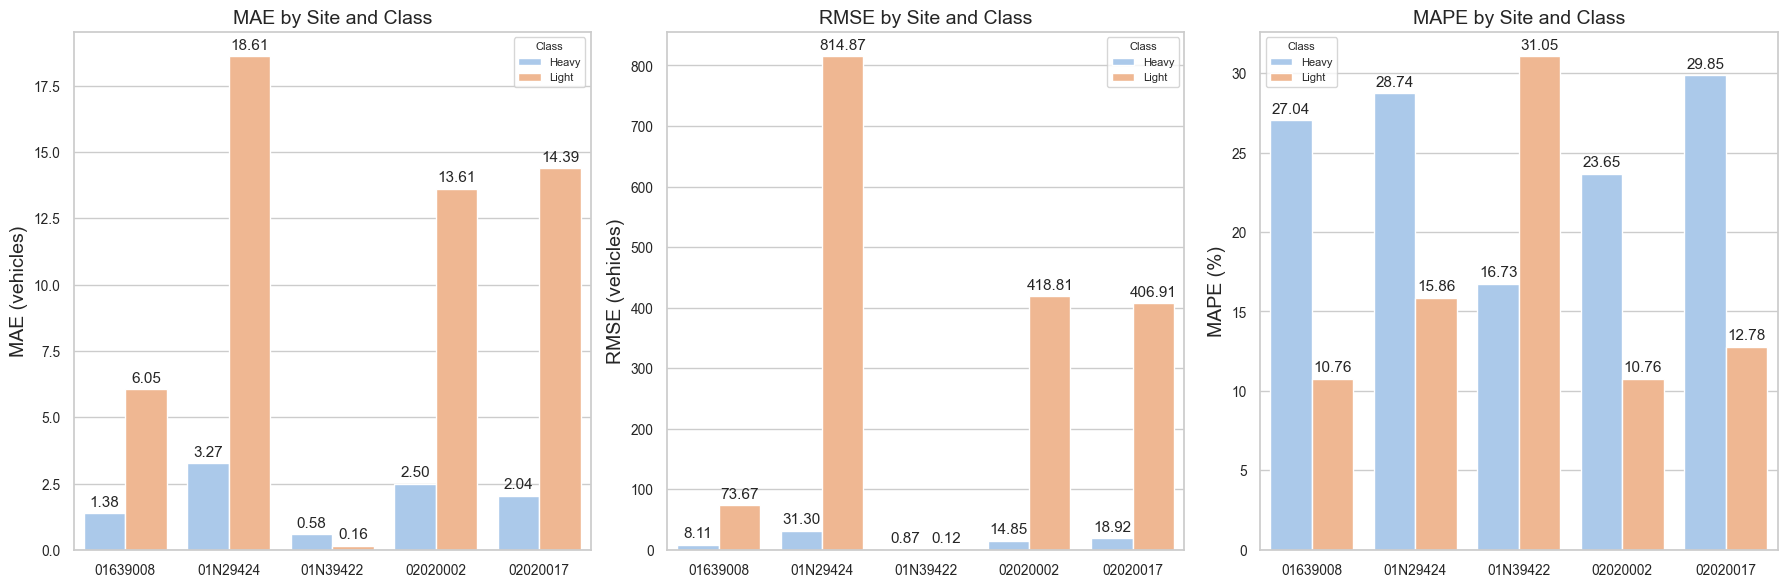

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('final_site_results.csv')
# Set plot style
sns.set(style="whitegrid", font_scale=0.9)

# Define y-axis units for each metric
y_units = {
    "MAE": " vehicles",
    "RMSE": " vehicles",
    "MAPE": " %"
}

# Create vertical bar charts with independent y-axis scales
metrics = ['MAE', 'RMSE', 'MAPE']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        ax=ax,
        data=df,
        x="SITE",
        y=metric,
        hue="CLASS WEIGHT",
        palette="pastel",
    )
    ax.set_title(f"{metric} by Site and Class", fontsize=14)
    # ax.set_xlabel("Site", fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel(f"{metric} ({y_units[metric].strip()})", fontsize=14)
    # ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Class", fontsize=8, title_fontsize=8)

    # Annotate bars with metric values + units
    for container in ax.containers:
        labels = [f'{bar.get_height():.2f}' for bar in container]
        ax.bar_label(container, labels=labels, fontsize=11, padding=3)

plt.tight_layout()
plt.show()


### Train model with 3 features 

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import os

# Create output directory for plots
os.makedirs("plots", exist_ok=True)

def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def plot_predictions(y_true, y_pred, site_id, cls):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true.reset_index(drop=True), label='Actual', alpha=0.7)
    plt.plot(y_pred, label='Predicted', alpha=0.7)
    plt.title(f"Actual vs Predicted - Site: {site_id}, Class: {cls}")
    plt.xlabel("Time Steps")
    plt.ylabel("Traffic Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/pred_{site_id}_{cls}.png")
    plt.close()

# Encode class
le_class = LabelEncoder()
model_df['class_enc'] = le_class.fit_transform(model_df['CLASS_WEIGHT'])

site_results = []
all_shap_values = []
all_X_test = []

for site_id in model_df['SITE_REFERENCE'].unique():
    site_df = model_df[model_df['SITE_REFERENCE'] == site_id].copy()

    for cls in ['Light', 'Heavy']:
        class_df = site_df[site_df['CLASS_WEIGHT'] == cls].copy()
        if len(class_df) < 100:
            continue

        print(f"\n🔧 Training model for site: {site_id}, class: {cls}")

        class_df['site_enc'] = 0
  
        features = [
            'rolling_mean_1h', 'rolling_std_1h', 'rolling_min_1h'
        ]

        X = class_df[features].copy()
        y = class_df['TRAFFIC_COUNT'].copy()

        X['START_DATE'] = class_df['START_DATE']
        X.sort_values('START_DATE', inplace=True)
        y = y.loc[X.index]

        split_idx = int(len(X) * 0.8)
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

        X_train = X_train.drop(columns=['START_DATE'])
        X_test = X_test.drop(columns=['START_DATE'])

        y_train_log = np.log1p(y_train)

        param_grid = {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5],
            'num_leaves': [15, 31],
            'min_child_samples': [10, 20]
        }

        base_model = lgb.LGBMRegressor()
        grid = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=0)
        grid.fit(X_train, y_train_log)

        model = grid.best_estimator_
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        mape_fixed = safe_mape(y_test.values, y_pred)

        print(f"  ▸ Best Params: {grid.best_params_}")
        print(f"  ▸ MAE: {mae:.2f}, RMSE: {rmse:.2f}, Fixed MAPE: {mape_fixed:.2f}%")

        site_results.append((site_id, cls, mae, rmse, mape_fixed, grid.best_params_))

        plot_predictions(y_test, y_pred, site_id, cls)

        # SHAP values collection
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        all_shap_values.append(shap_values.values)
        all_X_test.append(X_test)

# Summary Output
results_df = pd.DataFrame(site_results, columns=['SITE', 'CLASS WEIGHT', 'MAE', 'RMSE', 'MAPE', 'Best Params'])
#result df change floating point to 2 decimal places
results_df['MAE'] = results_df['MAE'].round(2)
results_df['RMSE'] = results_df['RMSE'].round(2)
results_df['MAPE'] = results_df['MAPE'].round(2)

# Drop best params for final output
results_df = results_df.drop(columns=['Best Params'])
# Add a column for site names
results_df['SITE DESCRIPTION'] = results_df['SITE'].map(site_dict)
# results_df['LANE NUMBER'] = results_df['SITE'].map()  # Assuming single lane for simplicity, can be adjusted if needed
#Change column order
results_df = results_df[['SITE', 'SITE DESCRIPTION', 'CLASS WEIGHT', 'MAE', 'RMSE', 'MAPE']]

results_df = results_df.sort_values(by='MAPE')
print("\n Final Evaluation Summary:")
print(results_df.to_string(index=False, formatters={
    'MAE': '{:.2f}'.format,
    'RMSE': '{:.2f}'.format,
    'MAPE': '{:.2f}%'.format
}))

results_df.to_csv("final_site_results(3_predictors).csv", index=False)

# Generate global SHAP plot
combined_shap = np.vstack(all_shap_values)
combined_X = pd.concat(all_X_test, axis=0)

# Rename for clarity
feature_rename = {
    "rolling_mean_1h": "Avg. past hour traffic",
    "rolling_std_1h": "Hourly volatility",
    "rolling_min_1h": "Min past hour"
}
combined_X = combined_X.rename(columns=feature_rename)

plt.figure(figsize=(10, 6))
shap.summary_plot(combined_shap, combined_X, plot_type="dot", max_display=10, show=False)
plt.tight_layout()
plt.savefig("plots/final_shap_summary(3_predictors)..png")
plt.close()



🔧 Training model for site: 01N29424, class: Light
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 14694, number of used features: 3
[LightGBM] [Info] Start training from score 4.537500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

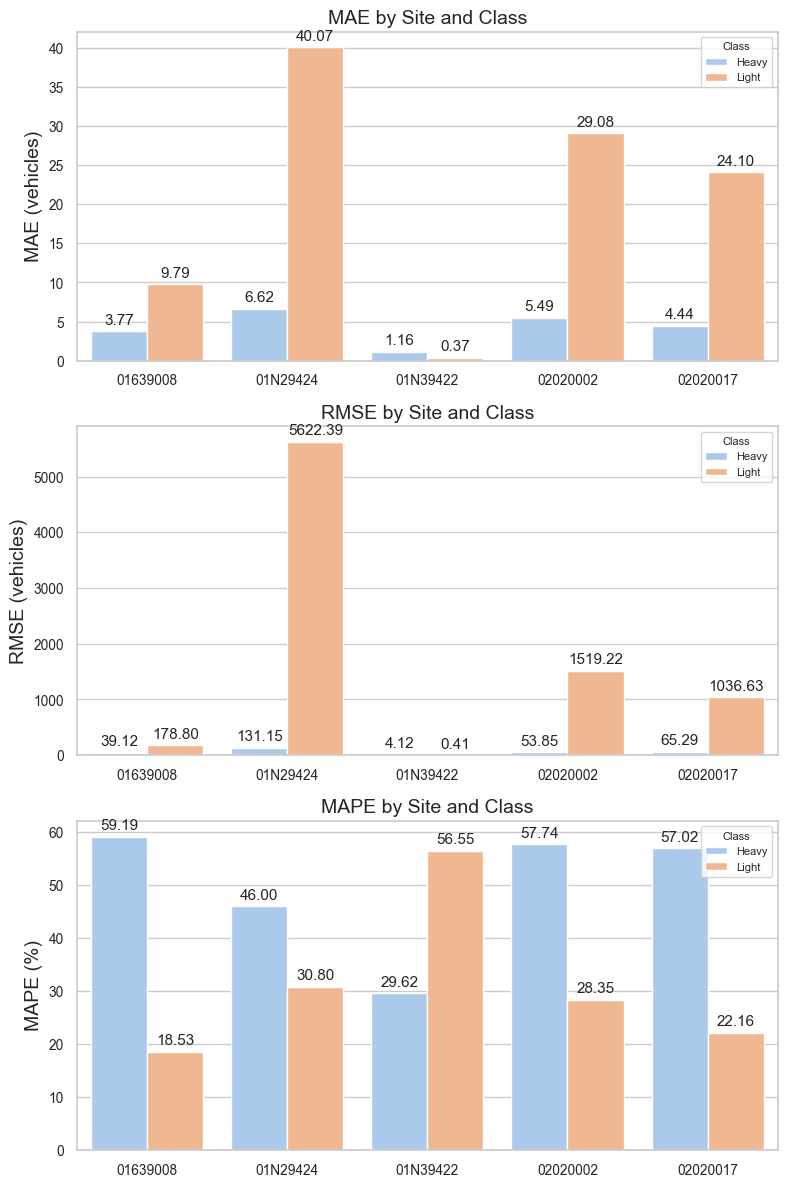

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('final_site_results(3_predictors).csv')
# Set plot style
sns.set(style="whitegrid", font_scale=0.9)

# Define y-axis units for each metric
y_units = {
    "MAE": " vehicles",
    "RMSE": " vehicles",
    "MAPE": " %"
}

# Create vertical bar charts with independent y-axis scales
metrics = ['MAE', 'RMSE', 'MAPE']
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        ax=ax,
        data=df,
        x="SITE",
        y=metric,
        hue="CLASS WEIGHT",
        palette="pastel",
    )
    ax.set_title(f"{metric} by Site and Class", fontsize=14)
    # ax.set_xlabel("Site", fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel(f"{metric} ({y_units[metric].strip()})", fontsize=14)
    # ax.tick_params(axis='x', rotation=45)
    ax.legend(title="Class", fontsize=8, title_fontsize=8)

    # Annotate bars with metric values + units
    for container in ax.containers:
        labels = [f'{bar.get_height():.2f}' for bar in container]
        ax.bar_label(container, labels=labels, fontsize=11, padding=3)

plt.tight_layout()
plt.show()
